### IBM_Applied-Data-Science-Capstone_Week3
- Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
- Author: Juan Carlos Villegas

#### Step 0: Import Required Libraries 

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
import folium # map rendering library
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

#### Step 1: Data Extracts from Wikpedia Page
- The code below shares explains how to extract a data table from wikepdia  and convert it into a usable df 

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' #creating a varibale for link
response = requests.get(wiki_url) 
soup = BeautifulSoup(response.text,'html.parser') #use BeautifulSoup to extract html from wiki page
table_id = "wikitable sortable"  #name of table after inspecting wiki page html
wiki_table = soup.find('table', attrs = {'class': 'wikitable sortable'}) #find table
wiki_table_df = pd.read_html(str(wiki_table))
wiki_table_df = wiki_table_df [0]

#### Step 2: Basic Data Transformations
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [3]:
wiki_table_df = wiki_table_df.loc[wiki_table_df['Borough'] != 'Not assigned' ] #removing cells with a borough that is Not assigned.

In [4]:
print(wiki_table_df.shape)  #getting shape of df

(103, 3)


#### Step 3: Getting Postal Codes
- Getting the postal code from the CSV

In [5]:
GPS = pd.read_csv("https://cocl.us/Geospatial_data") #reading in gps coordinates

In [6]:
PostalCodes_df = pd.merge(wiki_table_df,GPS,how = 'left', on =['Postal Code']) #merging tables

In [7]:
PostalCodes_df = PostalCodes_df.rename(columns={"Postal Code": "Postal_Code"})

#### Step 4: Creating Map of Tornto with Postal Codes 

In [8]:
#Getting coordinates for Toronto
address = 'Toronto'
geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [9]:
# create map of Tornto using latitude and longitude values
map_tr = folium.Map(location=[latitude, longitude], zoom_start=15)

# Creating aloop to pass all rows in df to graph in map 
for index, row in PostalCodes_df.iterrows():
    postal = row['Postal_Code']
    borough = row['Borough']
    lat = row['Latitude']
    lng = row['Longitude']
#Code specific for mapping 
    label = '{}, {}'.format(postal, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tr)
#Plot map
map_tr

#### Step 5: Getting Feature Data from Foodora API 
- Below is  the codes to setup and call API

In [27]:
# setting up credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# setting limits for query
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 250 # define radius
starting_latitude = '43.6534817'
starting_longitude = '-79.3839347'

# create URL for API Call
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    starting_latitude, 
    starting_longitude, 
    radius, 
    LIMIT)

#url # display URL

In [11]:
# calling API
results = requests.get(url).json()
#number of results in API call
totalResults = results['response']['totalResults'] 
print ("Extracted "+  str(totalResults) +  " records during API Call")  

Extracted 7 records during API Call


#### Step 6:  Data Formatting of Json to DF for Analysis
- Formatting json
- Getting venue type and venue id through loop 

In [12]:
# extracting main columns from json
venues = results['response']['groups'][0]['items']
# flatten json
nearby_venues = pd.json_normalize(venues) 

In [13]:
# creating df with relevant columns
nearby_venues = nearby_venues [['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]

# Adding Starting Point of Query into DF
nearby_venues['starting_latitude'] = starting_latitude
nearby_venues['starting_longitude'] = starting_longitude
nearby_venues['starting_name'] = "Toronto"

# getting venue types and ids from categories, and appending to nearby_venues df
N = len(nearby_venues ['venue.categories'])

venue_type_ls = []
ids_ls = []

for i in range(N):
    venue_type = nearby_venues ['venue.categories'] [i][0]['name']
    venue_type_ls.append(venue_type)
    
    ids = nearby_venues ['venue.categories'] [i][0]['id']
    ids_ls.append(ids)
    
nearby_venues['venue.type'] = venue_type_ls
nearby_venues['venue.id'] = ids_ls

# cleaning up df
nearby_venues.drop(['venue.categories'], axis=1)

,venue.name,venue.location.lat,venue.location.lng,starting_latitude,starting_longitude,starting_name,venue.type,venue.id
0,Downtown Toronto,43.653232,-79.385296,43.6534817,-79.3839347,Toronto,Neighborhood,4f2a25ac4b909258e854f55f
1,Nathan Phillips Square,43.652270,-79.383516,43.6534817,-79.3839347,Toronto,Plaza,4bf58dd8d48988d164941735
2,Poke Guys,43.654895,-79.385052,43.6534817,-79.3839347,Toronto,Poke Place,5bae9231bedf3950379f89d4
3,Japango,43.655268,-79.385165,43.6534817,-79.3839347,Toronto,Sushi Restaurant,4bf58dd8d48988d1d2941735
4,Textile Museum of Canada,43.654396,-79.386500,43.6534817,-79.3839347,Toronto,Art Museum,4bf58dd8d48988d18f941735
5,Chatime 日出茶太,43.655542,-79.384684,43.6534817,-79.3839347,Toronto,Bubble Tea Shop,52e81612bcbc57f1066b7a0c
6,Tsujiri,43.655374,-79.385354,43.6534817,-79.3839347,Toronto,Tea Room,4bf58dd8d48988d1dc931735


#### Setp 7: Creating a Loop Consolidatedating Coes frmo Setp 5 and 6 and Using Inputs of Step 3

In [15]:
# setting up credentials
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# setting limits for query
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 250 # define radius

#Creating empty df to pass through loop
Columns = ['venue.name', 'venue.categories', 'venue.location.lat','venue.location.lng', 'venue.type', 'venue.id']
nearby_venues_summary = pd.DataFrame(columns = Columns)

#Loop Start #
for index, row in PostalCodes_df.iterrows():
    
    starting_latitude = str (PostalCodes_df ['Latitude'] [index])
    starting_longitude = str (PostalCodes_df ['Longitude'] [index])
    
    
    # create URL for API Call
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        starting_latitude, 
        starting_longitude, 
        radius, 
        LIMIT)

    # calling API
    results = requests.get(url).json()
    #number of results in API call
    totalResults = results['response']['totalResults'] 
    print ("Extracted "+  str(totalResults) +  " records during API Call") 

    if totalResults == 0: 
        continue  #pass to next if no records are returned from API call  
    
    # extracting main columns from json
    venues = results['response']['groups'][0]['items']
    # flatten json
    nearby_venues = pd.json_normalize(venues) 
    # creating df with relevant columns
    nearby_venues = nearby_venues [['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']]

    
    # getting venue types and ids from categories, and appending to nearby_venues df
    N = len(nearby_venues ['venue.categories'])
    venue_type_ls = []
    ids_ls = []

    for i in range(N):
        venue_type = nearby_venues ['venue.categories'] [i][0]['name']
        venue_type_ls.append(venue_type)
        ids = nearby_venues ['venue.categories'] [i][0]['id']
        ids_ls.append(ids)
    
    #Fomratting df#
    ############################################################################################
    # adding venue and id to nearby_venues df
    nearby_venues['venue.type'] = venue_type_ls
    nearby_venues['venue.id'] = ids_ls
    
    # adding starting point of postal code to nearby_venues df
    starting_PostalCode = str (PostalCodes_df ['Postal_Code'] [index])
    nearby_venues['starting_PostalCode'] = starting_PostalCode
    
    # creating summary df that containts results of each loop 
    nearby_venues_summary = pd.concat([nearby_venues_summary,nearby_venues])     
    ############################################################################################

#Loop End#        
print ("Compiling Complete")
nearby_venues_summary.head(2)

Extracted 1 records during API Call
Extracted 4 records during API Call
Extracted 10 records during API Call
Extracted 6 records during API Call
Extracted 3 records during API Call
Extracted 0 records during API Call
Extracted 0 records during API Call
Extracted 1 records during API Call
Extracted 6 records during API Call
Extracted 41 records during API Call
Extracted 4 records during API Call
Extracted 0 records during API Call
Extracted 0 records during API Call
Extracted 14 records during API Call
Extracted 3 records during API Call
Extracted 13 records during API Call
Extracted 4 records during API Call
Extracted 8 records during API Call
Extracted 0 records during API Call
Extracted 4 records during API Call
Extracted 3 records during API Call
Extracted 0 records during API Call
Extracted 1 records during API Call
Extracted 9 records during API Call
Extracted 25 records during API Call
Extracted 4 records during API Call
Extracted 3 records during API Call
Extracted 4 records dur

,venue.name,venue.categories,venue.location.lat,venue.location.lng,venue.type,venue.id,starting_PostalCode
0,Brookbanks Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.751976,-79.332140,Park,4bf58dd8d48988d163941735,M3A
0,Portugril,"[{'id': '4def73e84765ae376e57713a', 'name': 'P...",43.725819,-79.312785,Portuguese Restaurant,4def73e84765ae376e57713a,M4A


#### Step 8: Creating df for culster anlaysis inputs

In [16]:
 # Creating df for anlaysis
nearby_venues_summary = nearby_venues_summary.drop(['venue.categories'], axis=1)
nearby_venues_summary = nearby_venues_summary.reset_index()
nearby_venues_summary = nearby_venues_summary.rename(columns={"starting_PostalCode": "Postal_Code",
                                                              "venue.name": "venue_name",
                                                              "venue.location.lat":"venue_location_lat",
                                                              "venue.location.lng": "venue_location_lng",
                                                              "venue.type": "venue_type", 
                                                              "venue.id":"venue_id" })

In [17]:
#reading in ad-hoc csv that contains a mappring of venue types to segments
venue_segments = pd.read_csv("C:/Users/jcvil/Desktop/Git-Hub-Projects/Coursera_Capstone/VenueSegments.csv") 

In [19]:
Analysis_df = pd.merge(PostalCodes_df,nearby_venues_summary,how = 'left', on =['Postal_Code'])
Analysis_df = pd.merge(Analysis_df,venue_segments,how = 'left', on =['venue_type'])
Analysis_df.head()

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude,index,venue_name,venue_location_lat,venue_location_lng,venue_type,venue_id,venue_segment
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Brookbanks Park,43.751976,-79.332140,Park,4bf58dd8d48988d163941735,Services/Place
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Portugril,43.725819,-79.312785,Portuguese Restaurant,4def73e84765ae376e57713a,Restaurant/Bar
2,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Tim Hortons,43.725517,-79.313103,Coffee Shop,4bf58dd8d48988d1e0931735,Restaurant/Bar
3,M4A,North York,Victoria Village,43.725882,-79.315572,2.0,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,Intersection,52f2ab2ebcbc57f1066b8b4c,Services/Place
4,M4A,North York,Victoria Village,43.725882,-79.315572,3.0,Pizza Nova,43.725824,-79.312860,Pizza Place,4bf58dd8d48988d1ca941735,Restaurant/Bar


#### Step 9: Generating Cluster

In [20]:
# one hot encoding
venue_onehot = pd.get_dummies(Analysis_df[['venue_segment']], prefix="", prefix_sep="")
venue_onehot['Postal_Code'] = Analysis_df['Postal_Code']
postal_grouped = venue_onehot.groupby('Postal_Code').mean().reset_index()
postal_grouped_clustering = postal_grouped.drop('Postal_Code', 1)

In [ ]:
postal_grouped_clustering.head(100)

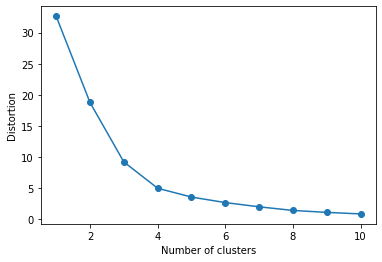

In [21]:
# Determine best number of clusters K. Calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(postal_grouped_clustering)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [22]:
# Running Cluster Analysis with ideal number of clusters
k_clusters = 3
# run k-means clustering
km = KMeans(n_clusters = k_clusters, random_state=0).fit(postal_grouped_clustering)

#### Step 10: Anlaysis

In [23]:
#Adding lables to postal code df 
labels = list(km.labels_)
postal_grouped ['Clusters'] = labels
postal_grouped.head(100)
#Creating final df for mapping and for analysis
PostalCodes_df_final = pd.merge(PostalCodes_df,postal_grouped,how = 'left', on =['Postal_Code']) #merging tables
PostalCodes_df_final.head()

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude,Restaurant/Bar,Services/Place,Store,Clusters
0,M3A,North York,Parkwoods,43.753259,-79.329656,0.00,1.000000,0.000000,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.75,0.250000,0.000000,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.30,0.400000,0.300000,2
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.00,0.166667,0.833333,2
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.00,0.000000,0.000000,0


In [25]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(PostalCodes_df_final['Latitude'], PostalCodes_df_final['Longitude'],PostalCodes_df_final['Postal_Code'], PostalCodes_df_final['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Text(0.5, 1.0, 'Store')

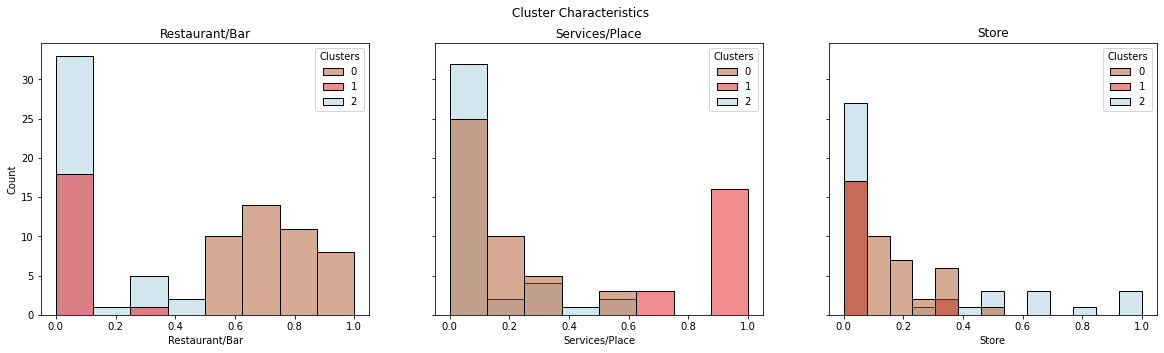

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Cluster Characteristics')

# Restaurant/Bar
sns.histplot(ax=axes[0],data = PostalCodes_df_final, x="Restaurant/Bar", hue="Clusters", fill=True, palette = "Paired_r")
axes[0].set_title("Restaurant/Bar")

# Restaurant/Bar
sns.histplot(ax=axes[1],data = PostalCodes_df_final, x="Services/Place", hue="Clusters", fill=True, palette = "Paired_r")
axes[1].set_title("Services/Place")

# Restaurant/Bar
sns.histplot(ax=axes[2],data = PostalCodes_df_final, x="Store", hue="Clusters", fill=True, palette = "Paired_r")
axes[2].set_title("Store")

#### Conlussions: 
- Cluster 0: Geographically centered around down town Toronto with high penetration of Restaurant/Bars 
- Cluster 1: Geographically spread with high penetration of services
- Cluster 2: Geographically spread, and overall low density areas  